In [1]:
import akshare
import pandas
import os
import json
import matplotlib.pyplot as plt

current_path = os.path.abspath('')
df = pandas.read_excel(current_path + '/../data/data.xlsx')
df2 = pandas.read_excel(current_path + '/../data/正股价格.xlsx', converters={'股票代码':str})

df['上市公告日期'] = pandas.to_datetime(df['上市公告日期'], format="%Y-%m-%d")
df['网上发行日期_x'] = pandas.to_datetime(df['网上发行日期_x'], format="%Y-%m-%d")
df['T-2日'] = pandas.to_datetime(df['T-2日'], format="%Y-%m-%d")

# 2019年至2022年11月18日 共558只可转债
start = pandas.Timestamp("2019-01-01")
end = pandas.Timestamp("2022-11-18")

df = df[(df['上市公告日期'] >= start) & (df['上市公告日期'] <= end)]
df = df.sort_values(by="T-2日", ascending=True)

daily = pandas.read_excel(current_path + '/../data/交易日历.xlsx')
daily = daily[(daily['trade_date'] >= start - pandas.to_timedelta('30 days')) & (daily['trade_date'] <= end)]

daily.insert(1, 'operation', json.dumps({}))
daily.insert(2, 'position', json.dumps({}))

daily.insert(3, 'balance', 0)
daily.insert(4, 'balance_in', 0)
daily.insert(5, 'balance_out', 0)
daily.insert(6, 'daily_ret', 0)
daily.insert(7, 'ret', 1)
daily.insert(8, 'balance_ret', 0)
daily.insert(9, 'balance_occupation', 0)


def strategy(cb):
    return True


for idx, row in df.iterrows():
    if strategy(row):
        # T-2日买入股票
        d1 = {}
        symbol = row['证券代码'][1:-1].replace('\'', '').replace(' ', '').split(',')
        d1[symbol[0]] = int(1000 / row['每股配售（元）'])
        d2 = json.loads(daily.loc[daily['trade_date'] == row['T-2日'], 'operation'].iloc[0])
        d2.update(d1)
        daily.loc[daily['trade_date'] == row['T-2日'], 'operation'] = json.dumps(d2)

        # T日卖出股票
        d3 = {}
        d3[symbol[0]] = -1 * d1[symbol[0]]
        d4 = json.loads(daily.loc[daily['trade_date'] == row['网上发行日期_x'], 'operation'].iloc[0])
        d4.update(d3)
        daily.loc[daily['trade_date'] == row['网上发行日期_x'], 'operation'] = json.dumps(d4)

        # T日交款配售10张可转债（1手）
        d5 = {}
        d5[symbol[1]] = 10
        d6 = json.loads(daily.loc[daily['trade_date'] == row['网上发行日期_x'], 'operation'].iloc[0])
        d6.update(d5)
        daily.loc[daily['trade_date'] == row['网上发行日期_x'], 'operation'] = json.dumps(d6)

        # 可转债上市日卖出可转债
        d7 = {}
        d7[symbol[1]] = -10
        d8 = json.loads(daily.loc[daily['trade_date'] == row['上市公告日期'], 'operation'].iloc[0])
        d8.update(d7)
        daily.loc[daily['trade_date'] == row['上市公告日期'], 'operation'] = json.dumps(d8)

        
position = {}
for idx, val in daily.iterrows():
    operation = json.loads(val['operation'])
    date = val['trade_date'].strftime("%Y-%m-%d")
    balance_in = val['balance_in']
    balance_out = val['balance_out']
    for symbol, value in operation.items():
        if value > 0:
            if not df2.loc[(df2['股票代码']==symbol) & (df2['日期']==date)].empty:
                idx_price = df2.loc[(df2['股票代码']==symbol) & (df2['日期']==date)].index[0]
                balance_in = balance_in + value * df2.at[idx_price, '均价']
            else:
                balance_in = balance_in + 1000
        else:
            if not df2.loc[(df2['股票代码'] == symbol) & (df2['日期'] == date)].empty:
                idx_price = df2.loc[(df2['股票代码']==symbol) & (df2['日期']==date)].index[0]
                balance_out = balance_out + -1 * value * df2.at[idx_price, '均价']
            else:
                idx_price = df[(df['证券代码'].str.contains(symbol)) & (df['上市公告日期']==date)].index[0]
                balance_out = balance_out + 10 * df.at[idx_price, '可转债上市当天成交均价']
        if symbol not in position.keys():
            position[symbol] = value
        else:
            position[symbol] = position[symbol] + value
            if position[symbol] == 0:
                position.pop(symbol)
    daily.loc[idx, 'position'] = json.dumps(position)
    daily.loc[idx, 'balance_in'] = balance_in
    daily.loc[idx, 'balance_out'] = balance_out

row1 = True

for idx, val in daily.iterrows():
    if row1:
        row1 = False
        continue
    position = json.loads(val['position'])
    date = val['trade_date'].strftime("%Y-%m-%d")
    balance_in = val['balance_in']
    balance_out = val['balance_out']
    balance = 0
    for symbol, val in position.items():
        if not df2.loc[(df2['股票代码'] == symbol) & (df2['日期'] == date)].empty:
            idx_price = df2.loc[(df2['股票代码'] == symbol) & (df2['日期'] == date)].index[0]
            balance = balance + val * df2.at[idx_price, '收盘']
        else:
            balance = balance + 1000
    daily.loc[idx, 'balance'] = balance
    if daily.at[idx-1, 'balance'] + balance_in == 0:
        daily.loc[idx, 'daily_ret'] = 0
        daily.loc[idx, 'ret'] = 1
        continue
    daily.loc[idx, 'daily_ret'] = (balance + balance_out) / (daily.at[idx-1, 'balance'] + balance_in) - 1
    daily.loc[idx, 'ret'] = daily.at[idx-1, 'ret'] * (1+daily.at[idx, 'daily_ret'])
    daily.loc[idx, 'balance_ret'] = daily.loc[idx-1, 'balance_ret'] + (balance + balance_out) - (daily.at[idx-1, 'balance'] + balance_in)
    daily.loc[idx, 'balance_occupation'] = daily.loc[idx-1, 'balance_occupation'] + balance_in - balance_out
#print(daily)


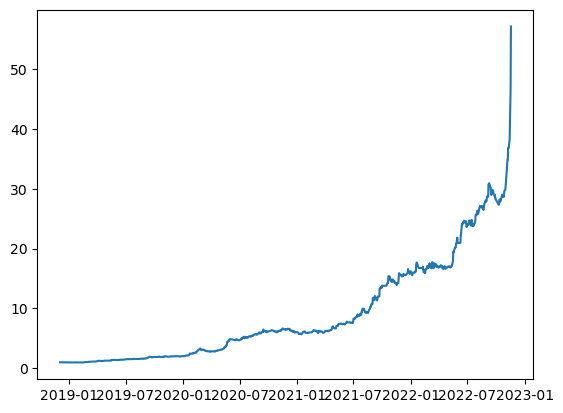

In [2]:
plt.plot(daily['trade_date'], daily['ret'])
plt.show()

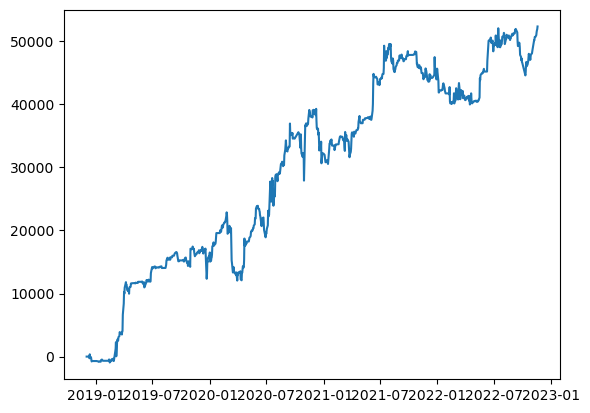

In [3]:
plt.plot(daily['trade_date'], daily['balance_ret'])
plt.show()

In [4]:
print(daily['balance_ret'])

6836        0.000000
6837        0.000000
6838        0.000000
6839        0.000000
6840        0.000000
            ...     
7793    50970.559185
7794    51456.385706
7795    51730.167153
7796    51899.482434
7797    52338.650965
Name: balance_ret, Length: 962, dtype: float64


In [6]:
print(daily['balance_occupation'].max())

197103.78464968986


In [9]:
print(daily['balance'].mean())

27619.718014553015


In [10]:
print(daily['daily_ret'].mean())

0.004398665246411545


In [13]:
print(daily['daily_ret'].idxmax())

7797
